In [2]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ncxt_psftomo
from tqdm.auto import tqdm

In [227]:
def find_instr(func, keyword, sig=0, limit=5):
    count = 0
    for l in func.inspect_asm(func.signatures[sig]).split('\n'):
        if keyword in l:
            count += 1
            print(l)
            if count >= limit:
                break
    if count == 0:
        print('No instructions found')

In [228]:

print('index0:')
find_instr(testnd0, keyword='addp', sig=0)
print('index1:')
find_instr(testnd1, keyword='addp', sig=0)
print('index2:')
find_instr(testnd2, keyword='addp', sig=0)
print('index2 twoop:')
find_instr(testnd2_twoop, keyword='addp', sig=0)

index0:
No instructions found
index1:
	vaddpd	-96(%rdx), %ymm0, %ymm0
	vaddpd	-64(%rdx), %ymm1, %ymm1
	vaddpd	-32(%rdx), %ymm2, %ymm2
	vaddpd	(%rdx), %ymm3, %ymm3
index2:
	vaddpd	(%r14,%rbx,8), %ymm0, %ymm0
	vaddpd	32(%r14,%rbx,8), %ymm1, %ymm1
	vaddpd	64(%r14,%rbx,8), %ymm2, %ymm2
	vaddpd	96(%r14,%rbx,8), %ymm3, %ymm3
index2 twoop:
No instructions found


In [229]:
from ncxt_psftomo.numba import A_psf_order
print('---\nA_psf_order:')
find_instr(A_psf_order, keyword='subp', sig=1)
find_instr(A_psf_order, keyword='addp', sig=1)
find_instr(A_psf_order, keyword='mulp', sig=1)


---
A_psf_order:


IndexError: list index out of range

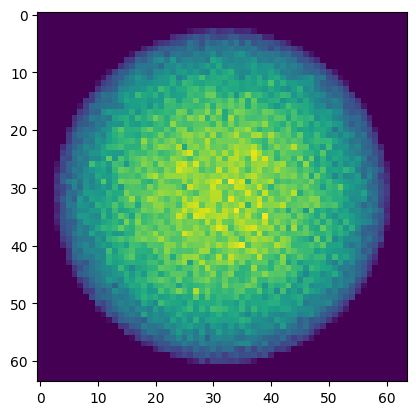

In [311]:
L = 64
n_images = 16
angles = np.linspace(-np.pi/2, np.pi/2, n_images)

C = (L-1)/2
X,Y,Z =np.meshgrid(np.arange(L)-C,np.arange(L)-C,np.arange(L)-C, indexing='ij') 
phantom = (1.0*((X**2+Y**2+Z**2) < (L/2.2)**2))*np.random.random((L,L,L))
phantom = phantom.astype('float32')
# phantom = np.zeros((L,L,L))
# phantom[L//2,L//2,L//2]=1
projections_bl = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
ncxt_psftomo.forward_bl(1.0*phantom, projections_bl, angles)
plt.imshow(projections_bl[0].transpose())
plt.show()

resolution = 1
dof = 50
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,3,2*L+1)

In [312]:
from ncxt_psftomo.numba import A_psf_order, A_psf_order_dot
psf_proj0 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
psf_proj1 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))

A_psf_order(phantom, psf_proj0,psf,angles)
A_psf_order_dot(phantom, psf_proj1,psf,angles)


In [313]:
print(np.linalg.norm(psf_proj0-psf_proj1))

%timeit A_psf_order(phantom, psf_proj0,psf,angles)
%timeit A_psf_order_dot(phantom, psf_proj1,psf,angles)

6.6270600918885
187 ms ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
91.6 ms ± 5.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


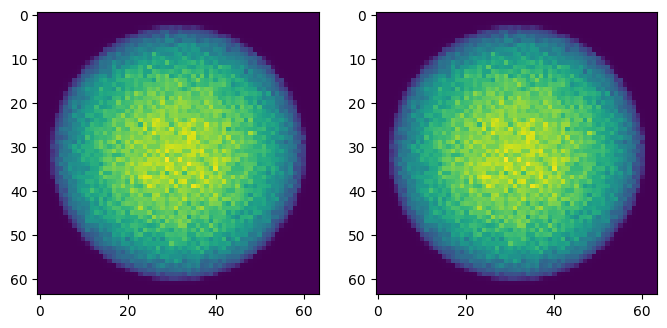

In [314]:
f,(ax1,ax2)= plt.subplots(ncols=2, figsize = (8,5))
ax1.imshow(psf_proj0[0,:,:])
ax2.imshow(psf_proj1[0,:,:])
plt.show()

In [125]:
from ncxt_psftomo.numba import A_bl, sA_bl
numba_bl32 = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]),dtype='float32')
numba_bl64 = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]),dtype='float64')
# dry run
A_bl(phantom, numba_bl32, angles)
A_bl(phantom, numba_bl64, angles)
sA_bl(phantom, numba_bl32, angles)
sA_bl(phantom, numba_bl64, angles)

%timeit A_bl(phantom, numba_bl32, angles)
%timeit A_bl(phantom, numba_bl64, angles)

%timeit sA_bl(phantom, numba_bl32, angles)
%timeit sA_bl(phantom, numba_bl64, angles)

1.43 ms ± 167 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
965 μs ± 52.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
675 μs ± 40 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.28 ms ± 169 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


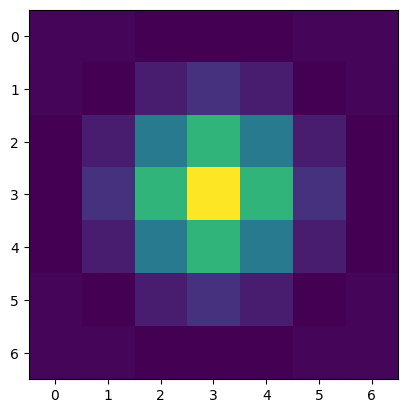

0.9999999999999999


In [126]:
resolution = 3
dof = 50
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,3,2*L+1)
plt.imshow(psf[L,:,:])
plt.show()
print(np.sum(psf[L,:,:]))

In [128]:
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
ncxt_psftomo.forward(1.0*phantom, projections, psf, angles)

psf_proj_32 = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]),dtype='float32')
psf_proj_64 = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]),dtype='float64')


%timeit ncxt_psftomo.forward(1.0*phantom, projections, psf, angles)
%timeit A_psf(phantom, psf_proj_64,psf,angles)
%timeit A_psf2(phantom, psf_proj_64,psf,angles)

%timeit A_psf(phantom, psf_proj_32,psf,angles)
%timeit A_psf2(phantom, psf_proj_32,psf,angles)


402 ms ± 55.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
218 ms ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
641 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
235 ms ± 8.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
631 ms ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [129]:
from ncxt_psftomo.numba import A_bl, sA_bl, A_psf,A_psf_inline,A_psf_order,A_psf_order_s
psf_proj0 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
psf_proj1 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
psf_proj2 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
psf_proj3 = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]), dtype='float32')
s_psf = psf.astype('float32')
s_angles = angles.astype('float32')


A_psf(phantom, psf_proj0,psf,angles)
A_psf_inline(phantom, psf_proj1,psf,angles)
A_psf_order(phantom, psf_proj2,psf,angles)
A_psf_order_s(phantom, psf_proj3,s_psf,s_angles)

print(np.linalg.norm(psf_proj0-psf_proj1))
print(np.linalg.norm(psf_proj0-psf_proj2))
print(np.linalg.norm(psf_proj0-psf_proj3))

0.0
0.0
0.1819229311009324


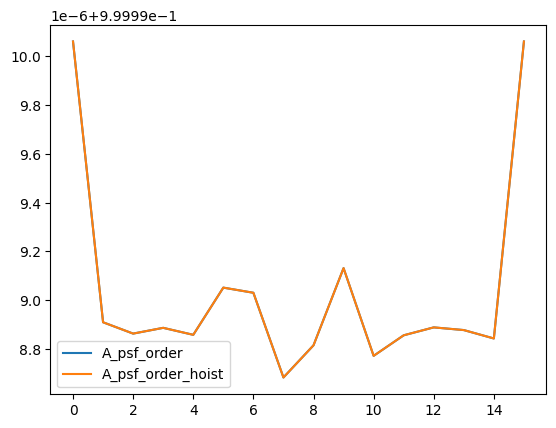

218 ms ± 57.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
160 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
153 ms ± 8.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
from ncxt_psftomo.numba import A_psf_order,A_psf_order_hoist
A_psf_order(phantom, psf_proj1,s_psf,s_angles)
A_psf_order_hoist(phantom, psf_proj2,s_psf,s_angles)
plt.plot(np.sum(np.sum(psf_proj1,-1),-1)/np.sum(phantom),label = 'A_psf_order', )
plt.plot(np.sum(np.sum(psf_proj2,-1),-1)/np.sum(phantom),label = 'A_psf_order_hoist', )
plt.legend()
plt.show()

# %timeit A_psf(phantom, psf_proj1,psf,angles)
%timeit A_psf_inline(phantom, psf_proj2,psf,angles)
%timeit A_psf_order(phantom, psf_proj2,psf,angles)
%timeit A_psf_order_hoist(phantom, psf_proj2,psf,angles)
# %timeit A_psf_order_s(phantom, psf_proj3,s_psf,s_angles)

float32:
No instructions found
---
float64:
No instructions found


In [147]:
%timeit A_psf_order(phantom, psf_proj2,psf,angles)
%timeit A_psf_order_hoist(phantom, psf_proj2,psf,angles)

154 ms ± 5.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
152 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


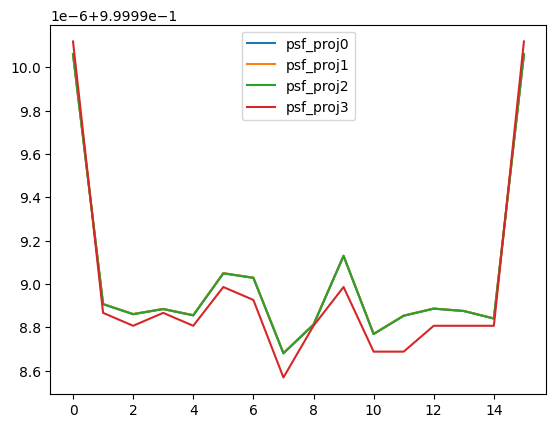

In [140]:
plt.plot(np.sum(np.sum(psf_proj0,-1),-1)/np.sum(phantom),label = 'psf_proj0', )
plt.plot(np.sum(np.sum(psf_proj1,-1),-1)/np.sum(phantom),label = 'psf_proj1', )
plt.plot(np.sum(np.sum(psf_proj2,-1),-1)/np.sum(phantom),label = 'psf_proj2', )
plt.plot(np.sum(np.sum(psf_proj3,-1),-1)/np.sum(phantom),label = 'psf_proj3', )

plt.legend()
plt.show()

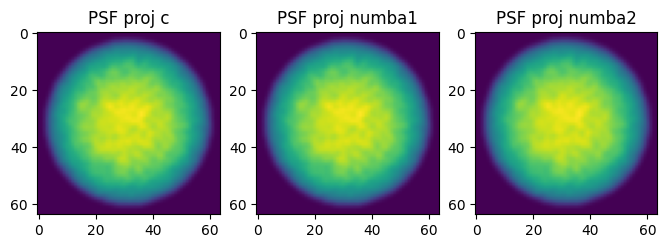

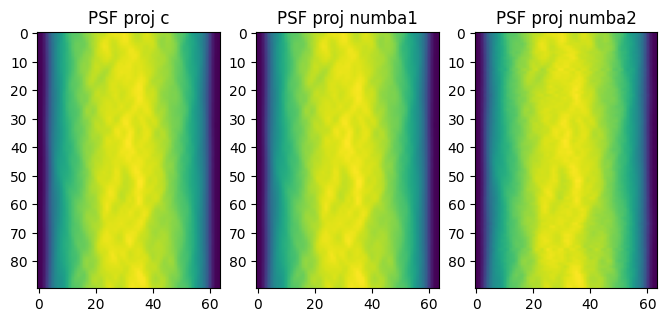

In [66]:
f,(ax1,ax2,ax3)= plt.subplots(ncols=3, figsize = (8,5))
ax1.imshow(psf_proj1[0,:,:])
ax2.imshow(psf_proj2[0,:,:])
ax3.imshow(psf_proj3[0,:,:])

ax1.set_title("PSF proj c")
ax2.set_title("PSF proj numba1")
ax3.set_title("PSF proj numba2")
plt.show()

vertical_index = L//2
f,(ax1,ax2,ax3)= plt.subplots(ncols=3, figsize = (8,5))
ax1.imshow(psf_proj1[:,:,vertical_index])
ax2.imshow(psf_proj2[:,:,vertical_index])
ax3.imshow(psf_proj3[:,:,vertical_index])

ax1.set_title("PSF proj c")
ax2.set_title("PSF proj numba1")
ax3.set_title("PSF proj numba2")
plt.show()

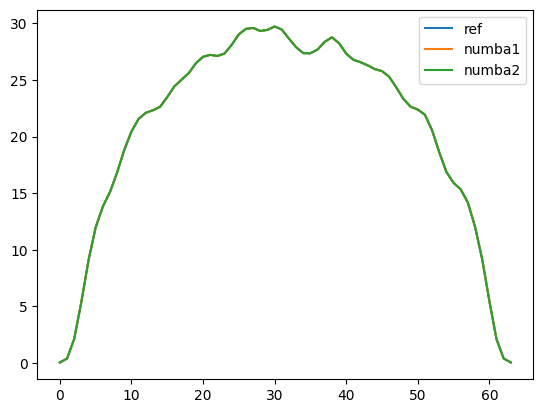

In [29]:
plt.plot(psf_proj0[0,:,vertical_index],label = 'ref')
plt.plot(psf_proj1[0,:,vertical_index],label = 'numba1')
plt.plot(psf_proj2[0,:,vertical_index],label = 'numba2')
plt.legend()
plt.show()

In [198]:
from ncxt_psftomo.numba import A_bl, sA_bl, A_psf,A_psf2
L = 64
n_images = 20
angles = np.linspace(-np.pi/2, np.pi/2, n_images)

C = (L-1)/2
X,Y,Z =np.meshgrid(np.arange(L)-C,np.arange(L)-C,np.arange(L)-C, indexing='ij') 
# phantom = (1.0*((X**2+Y**2+Z**2) < (L/10)**2))*np.random.random((L,L,L))/100
phantom = np.zeros((L,L,L))
phantom[L//2,L//2,L//2]=1

phantom = phantom.astype('float32')
psf_proj_32 = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]),dtype='float64')
psf_proj_64 = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]),dtype='float64')


resolution = 4
dof = L
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,5,2*L+1)
psf32 = psf.astype('float32')


A_psf(phantom, psf_proj_32,psf32,angles)
A_psf2(phantom, psf_proj_32,psf32,angles)
A_psf(phantom, psf_proj_64,psf,angles)
A_psf2(phantom, psf_proj_64,psf,angles)

%timeit A_psf(phantom, psf_proj_32,psf32,angles)
%timeit A_psf2(phantom, psf_proj_32,psf32,angles)

%timeit A_psf(phantom, psf_proj_64,psf,angles)
%timeit A_psf2(phantom, psf_proj_64,psf,angles)


570 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
330 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
535 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
343 ms ± 62.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [199]:
kw_y = 5
kr_y = int((kw_y - 1) / 2)

nh = 10 
ph = nh
zi = 0
for zi in range(4):
    print('zi = ',zi)
    ky0,ky1 = max(-kr_y, 0 - zi), min(ph - zi, kr_y+1)
    for ky in range(ky0,ky1):
        ind1 = zi + (ky)
        print(f"    from z{zi} k{ky} to p{ind1}")

zi =  0
    from z0 k0 to p0
    from z0 k1 to p1
    from z0 k2 to p2
zi =  1
    from z1 k-1 to p0
    from z1 k0 to p1
    from z1 k1 to p2
    from z1 k2 to p3
zi =  2
    from z2 k-2 to p0
    from z2 k-1 to p1
    from z2 k0 to p2
    from z2 k1 to p3
    from z2 k2 to p4
zi =  3
    from z3 k-2 to p1
    from z3 k-1 to p2
    from z3 k0 to p3
    from z3 k1 to p4
    from z3 k2 to p5


In [200]:
print(kw_y-kr_y)
print(kr_y+1)


3
3


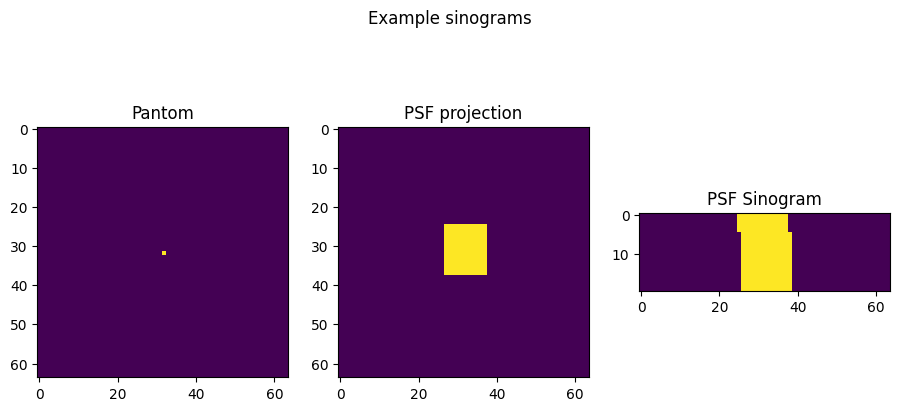

In [201]:
vertical_index = 40
f,(ax1,ax2,ax3)= plt.subplots(ncols=3, figsize = (11,5))
ax1.imshow(phantom[:,:,L//2])
ax2.imshow(psf_proj_64[0,:,:])
ax3.imshow(psf_proj_64[:,:,L//2])

plt.suptitle("Example sinograms")
ax1.set_title("Pantom")
ax2.set_title("PSF projection")
ax3.set_title("PSF Sinogram")

plt.show()

In [202]:
psf_proj_64.shape

(20, 64, 64)

In [203]:
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
projections_bl = np.zeros((len(angles),phantom.shape[0],phantom.shape[1]))
ncxt_psftomo.forward(1.0*phantom, projections, psf, angles)
ncxt_psftomo.forward_bl(1.0*phantom, projections_bl, angles)

In [204]:
from ncxt_psftomo.psf_utils import PSF_rz_vec
import sxtlac
from sxtlac.constants import PREFIX

def unit(unit):
    return 10**PREFIX[unit]

def psf_volume(resolution, depth_of_field, R, L, df):
    NA = resolution / (0.610 * depth_of_field)
    wavelength = depth_of_field * NA**2

    r = np.linspace(-R, R, 2 * R + 1)
    z = np.linspace(0, L, L) - L / 2+df
    zz, rr1,rr2 = np.meshgrid(z, r,r,indexing='ij')
    rr = np.sqrt(rr1**2+rr2**2)
    h = PSF_rz_vec(rr, zz, wavelength, NA)
    for h_slice in h:
        h_slice/=np.sum(h_slice)


    return h

In [205]:
# specs from jian-huas screenshots
E = 550
H = 4.135667696e-15 # eVs
C = 299792458 # m/s
WL = H*C/E

def mzp60(energy, energy_ref = 517):
    f0 = 1916*unit('um')
    ozw = 60*unit('nm')    
    NA = WL/(2*ozw)
    
    wl = H*C/energy
    resolution =0.61*wl/NA
    dof = wl/NA**2
    
    f_x = energy/E*f0
    f_ref = energy_ref/E*f0   
    deltaf = (f_x-f_ref)
    return resolution, dof,deltaf
    
def mzp35(energy,energy_ref = 517):
    energy0 = 550
    f0 = 931*unit('um')
    ozw = 35*unit('nm')     
    NA = WL/(2*ozw)
    
    wl = H*C/energy
    resolution =0.61*wl/NA
    dof = wl/NA**2
    
    f_x = energy/E*f0
    f_ref = energy_ref/E*f0   
    deltaf = (f_x-f_ref)
    return resolution, dof,deltaf

print(mzp35(517))
print(mzp60(517))
print(mzp80(517))




(4.542553191489362e-08, 2.3124086080863656e-06, 0.0)
(7.787234042553192e-08, 6.7956497870293184e-06, 0.0)


NameError: name 'mzp80' is not defined

In [5]:
n_sampling = 11

  0%|          | 0/11 [00:00<?, ?it/s]

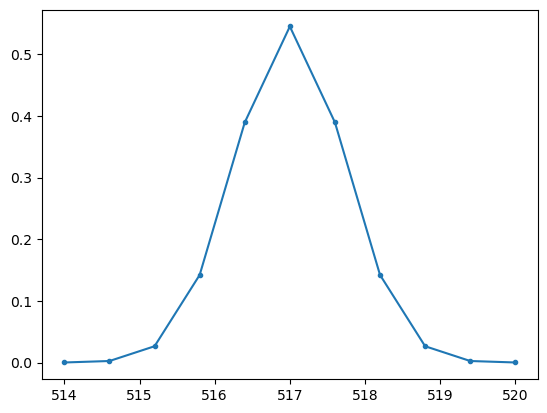

In [6]:
from scipy.stats import norm
n_sampling = 11
xx = np.linspace(517-3,517+3,n_sampling)
yy=norm.pdf(xx, loc = 517, scale = 517/300/2.355)
plt.plot(xx,yy,'.-')

L = 512
R = 3
pix = 36*unit('nm')

psf_list_60 = []
psf_list_35 = []

for energy in tqdm(xx):
    res, dof,f = mzp60(energy)        
    psf_list_60.append(psf_volume(res/pix, dof/pix, R, L,f/pix))
    
    res, dof,f = mzp35(energy)        
    psf_list_35.append(psf_volume(res/pix, dof/pix, R, L,f/pix))

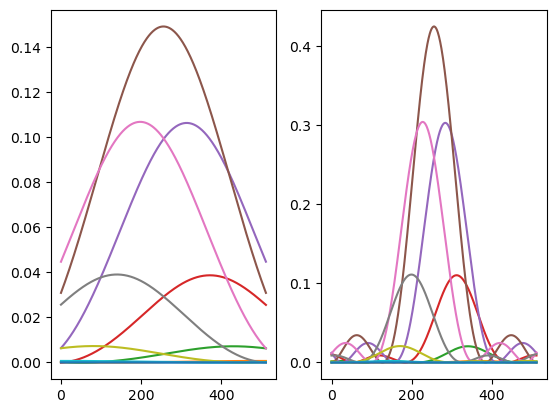

In [7]:
f, (ax1,ax2)= plt.subplots(ncols = 2)
for weight,psf in zip(yy,psf_list_60):
    ax1.plot(weight*psf[:,R,R])
for weight,psf in zip(yy,psf_list_35):
    ax2.plot(weight*psf[:,R,R])

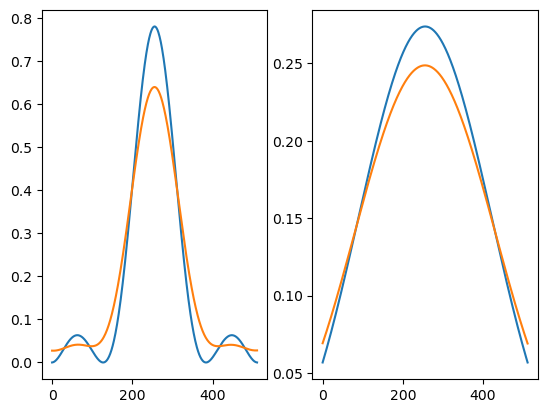

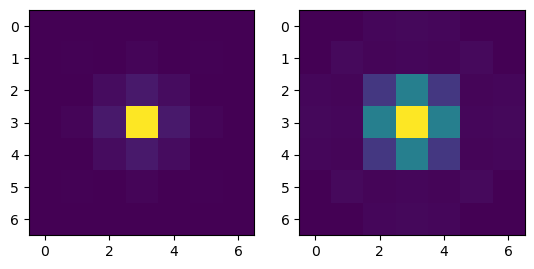

In [11]:
psf_eff_35 = np.sum([weight/np.sum(yy)*psf for weight,psf in zip(yy,psf_list_35) ],0)
psf_eff_60 = np.sum([weight/np.sum(yy)*psf for weight,psf in zip(yy,psf_list_60) ],0)


f, (ax1,ax2)= plt.subplots(ncols = 2)
ax1.plot(psf_list_35[n_sampling//2][:,R,R])
ax1.plot(psf_eff_35[:,R,R])

ax2.plot(psf_list_60[n_sampling//2][:,R,R])
ax2.plot(psf_eff_60[:,R,R])

f, (ax1,ax2)= plt.subplots(ncols = 2)
ax1.imshow(psf_eff_35[L//2,:,:])
ax2.imshow(psf_eff_60[L//2,:,:])

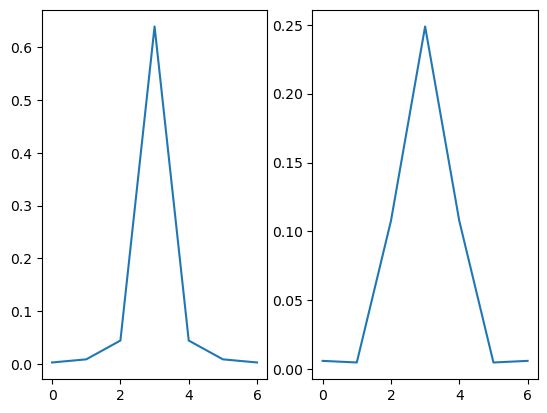

In [12]:
f, (ax1,ax2)= plt.subplots(ncols = 2)
ax1.plot(psf_eff_35[L//2,R,:])
ax2.plot(psf_eff_60[L//2,R,:])

(127, 126, 5)


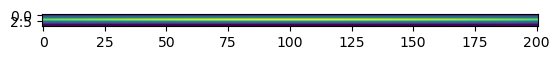

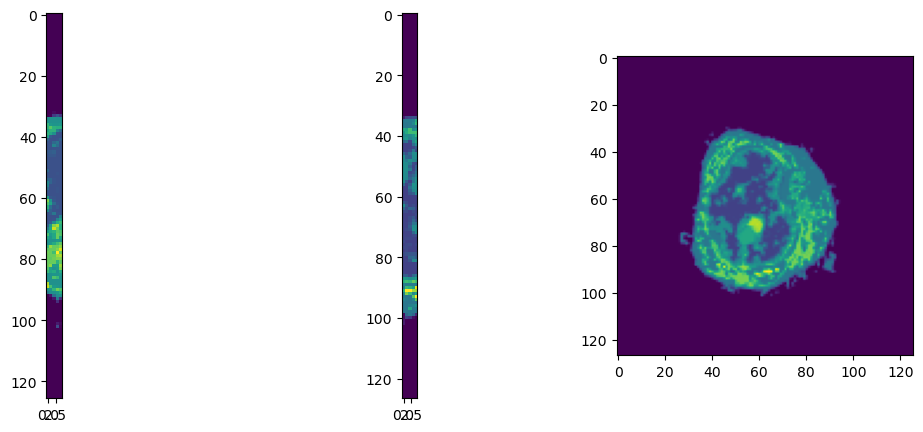

In [13]:
phantom = ncxt_psftomo.read_write_mrc.read_mrc('data/phantom.mrc')
phantom = ncxt_psftomo.read_write_mrc.read_mrc('data/phantom.mrc')[:-1,:-2,:-3]
phantom = phantom[:,:,60:-60]

resolution = 2
dof = 200
psf = ncxt_psftomo.psf_utils.psf_volume(resolution,dof,2,201)

plt.imshow(ncxt_psftomo.psf_utils.psf_slice(resolution,dof,2,201))
ncxt_psftomo.plotters.volshow(phantom)
print(phantom.shape)

In [14]:
phantom.shape

(127, 126, 5)

In [15]:
# psf= np.zeros((201,3,3))
# psf[:,1,1]=1

In [16]:
na = 100
angles = np.linspace(0,np.pi,na,endpoint = False)
projections = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]))
projections_bl = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]))

ncxt_psftomo.forward(phantom, projections, psf, angles)
ncxt_psftomo.forward_bl(phantom, projections_bl, angles)

In [17]:
np.linalg.norm(projections-projections_bl)

6337.129003950999

In [18]:
from ncxt_psftomo.numba import A_bl
numba_bl = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]))
A_bl(phantom, numba_bl, angles)
np.linalg.norm(numba_bl-projections_bl)

0.006444697151037826

In [19]:
from ncxt_psftomo.numba import A_psf
numba_psf = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]))
A_psf(phantom, numba_psf, psf,angles)
print(np.linalg.norm(numba_psf-numba_bl))
print(np.linalg.norm(numba_psf-projections_bl))
print()
print('proj sums')
print(np.sum(projections))
print(np.sum(projections_bl))
print(np.sum(numba_bl))
print(np.sum(numba_psf))




6337.134735288714
6337.132047386205

proj sums
62073335.585317
62070400.0
62070400.0
62073335.53657454


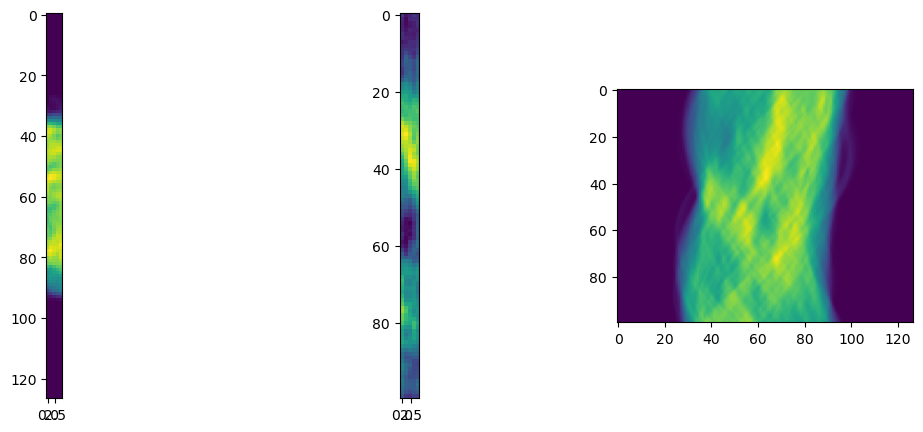

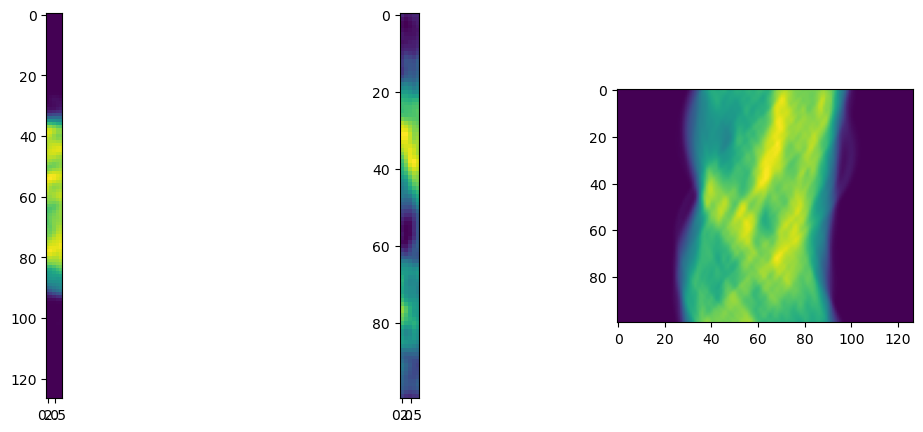

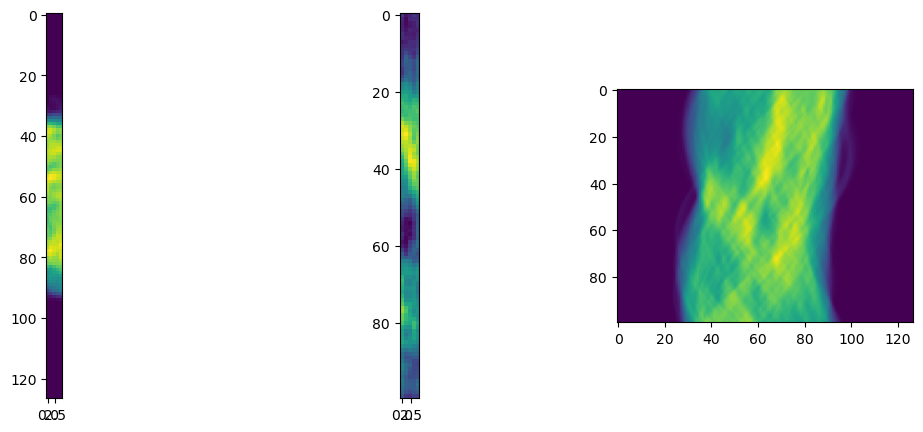

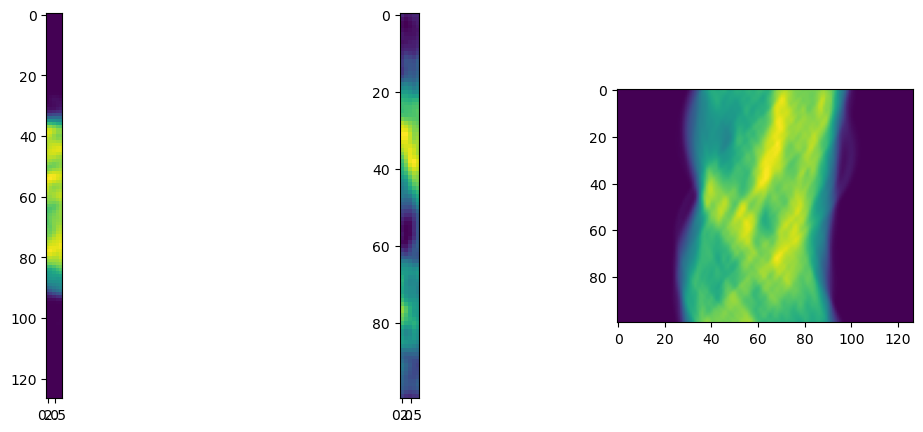

In [20]:
ncxt_psftomo.plotters.volshow(projections_bl)
ncxt_psftomo.plotters.volshow(projections)
ncxt_psftomo.plotters.volshow(numba_bl)
ncxt_psftomo.plotters.volshow(numba_psf)

In [359]:
from ncxt_psftomo.numba import A_psf
numba_psf = np.zeros((len(angles),phantom.shape[0],phantom.shape[2]))
%timeit A_psf(phantom, projections_bl_numba, psf,angles)

678 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [357]:

%timeit ncxt_psftomo.forward_bl(phantom, projections_bl, angles)
%timeit A_bl(phantom, projections_bl_numba, angles)

73.7 ms ± 2.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.4 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [364]:
%timeit ncxt_psftomo.forward(phantom, projections, psf, angles)
%timeit A_psf(phantom, projections_bl_numba, psf,angles)

1.26 s ± 4.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
661 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [137]:
%%time
ncxt_psftomo.forward(phantom, projections, psf, angles)

CPU times: total: 3.25 s
Wall time: 6.83 s


In [138]:
%%time
ncxt_psftomo.forward_bl(phantom, projections_bl, angles)

CPU times: total: 93.8 ms
Wall time: 404 ms


In [361]:
# check32
phantom32 = phantom.astype('float32')
projections32 = projections_bl_numba.astype('float32')

%timeit A_bl(phantom, projections_bl_numba, angles)
%timeit A_bl(phantom32, projections32, angles)


16.9 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.4 ms ± 838 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [363]:
# check32
phantom32 = phantom.astype('float32')
projections32 = numba_psf.astype('float32')
psf32 = psf.astype('float32')


%timeit A_psf(phantom, numba_psf, psf,angles)
%timeit A_psf(phantom32, projections32, psf32,angles)

633 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
672 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [105]:
psf.shape

(201, 11, 11)

In [127]:
from ncxt_psftomo.numba import A_psf
A_psf(phantom, projections_bl_numba, psf,angles)
print(np.sum(projections))
print(np.sum(projections_bl))
print(np.sum(projections_bl_numba))

615218100.0
615218100.0
87976188300.0


383 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
175 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


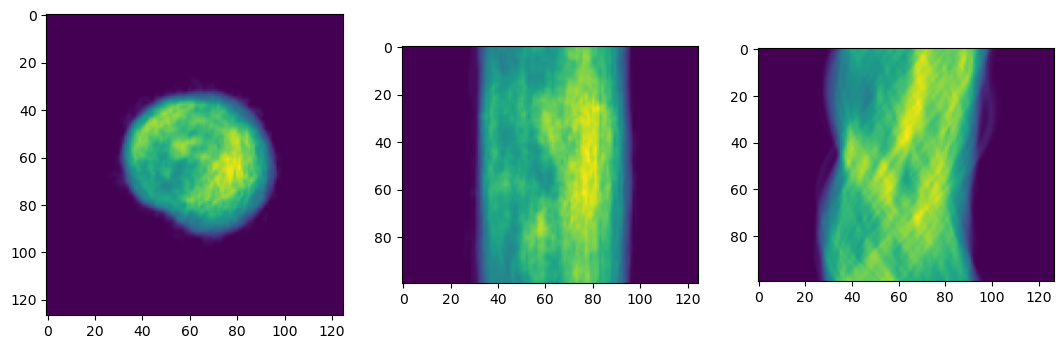

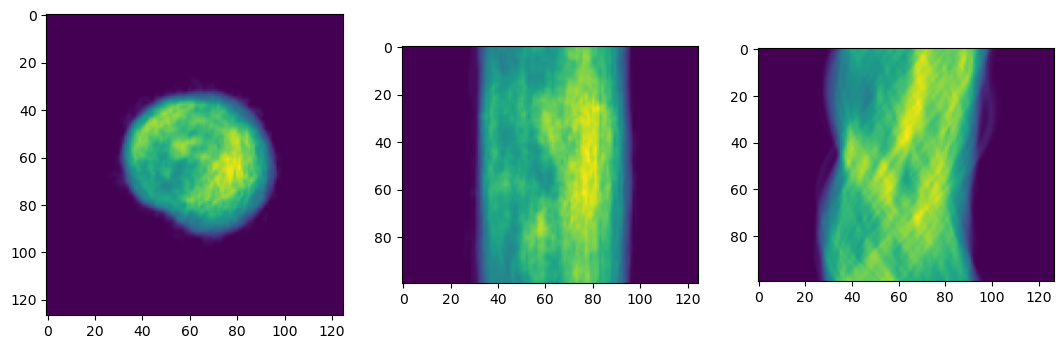

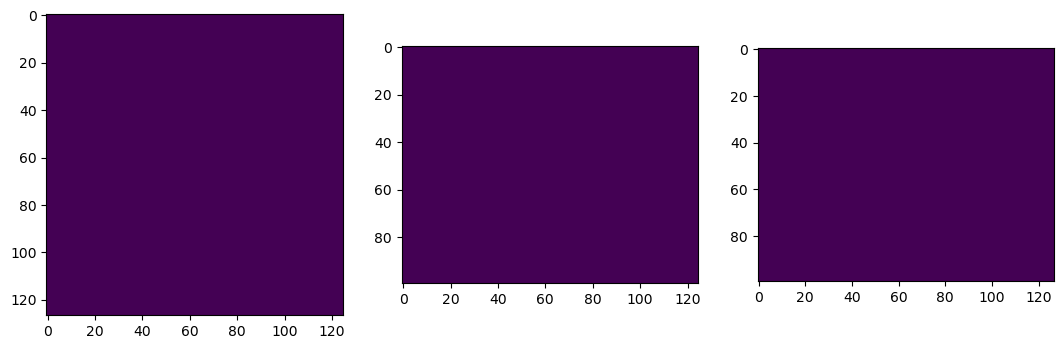

In [139]:
ncxt_psftomo.plotters.volshow(projections_bl)
ncxt_psftomo.plotters.volshow(projections)
ncxt_psftomo.plotters.volshow(projections_bl_numba)


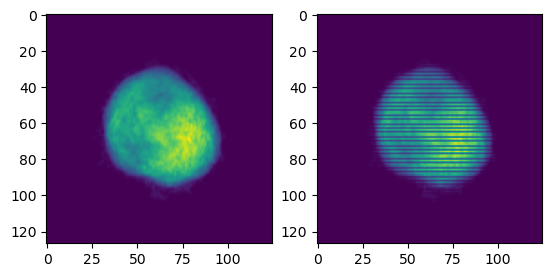

In [63]:
f, (ax1,ax2)= plt.subplots(ncols = 2)
index = 25
ax1.imshow(projections_bl[index])
ax2.imshow(projections_bl_numba[index])

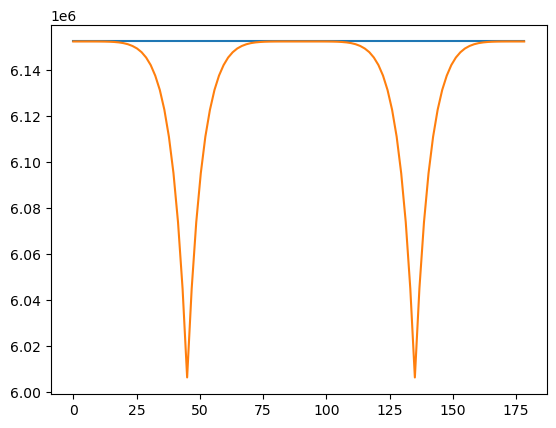

In [60]:
angles_deg = np.degrees(angles)
plt.plot(angles_deg,np.sum(np.sum(projections_bl,1),1))
plt.plot(angles_deg,np.sum(np.sum(projections_bl_numba,1),1))

In [62]:
for i,an in enumerate(angles_deg):
    print(i,an)

0 0.0
1 1.8
2 3.6
3 5.4
4 7.2
5 9.0
6 10.8
7 12.600000000000001
8 14.4
9 16.2
10 18.0
11 19.8
12 21.6
13 23.400000000000002
14 25.200000000000003
15 27.000000000000004
16 28.8
17 30.600000000000005
18 32.4
19 34.2
20 36.0
21 37.800000000000004
22 39.6
23 41.4
24 43.2
25 45.00000000000001
26 46.800000000000004
27 48.6
28 50.400000000000006
29 52.2
30 54.00000000000001
31 55.800000000000004
32 57.6
33 59.400000000000006
34 61.20000000000001
35 63.0
36 64.8
37 66.60000000000001
38 68.4
39 70.2
40 72.0
41 73.8
42 75.60000000000001
43 77.4
44 79.2
45 81.00000000000001
46 82.8
47 84.60000000000001
48 86.4
49 88.2
50 90.00000000000001
51 91.8
52 93.60000000000001
53 95.4
54 97.2
55 99.00000000000001
56 100.80000000000001
57 102.60000000000001
58 104.4
59 106.2
60 108.00000000000001
61 109.80000000000001
62 111.60000000000001
63 113.4
64 115.2
65 117.0
66 118.80000000000001
67 120.60000000000001
68 122.40000000000002
69 124.2
70 126.0
71 127.80000000000001
72 129.6
73 131.4
74 133.200000000000

In [ ]:
ncxt_psftomo.forward(phantom, projections, psf, angles)
ncxt_psftomo.forward_bl(phantom, projections_bl, angles)

In [ ]:
f,(ax1,ax2)= plt.subplots(ncols=2,figsize=(8,5))
ax1.imshow(projections_bl[0].transpose())
ax2.imshow(projections[0].transpose())
plt.suptitle("Projection images")
ax1.set_title("Beer-Lambert")
_ = ax2.set_title("PSF projection")

In [ ]:
f, (ax1,ax2) = plt.subplots(ncols = 2)
ax1.imshow(projections_bl[:,:,phantom.shape[2]//2])
ax2.imshow(projections[:,:,phantom.shape[2]//2])

In [ ]:
projections.shape

In [7]:
ncxt_psftomo.test_omp()

4